## The goal of this notebook is to build a model that can forecast day-ahead electricity prices for Bergen, Norway (NO5). The motivation is practical rather than academic. Day-ahead prices are published daily and strongly influence household behavior, industrial planning, and energy awareness.

## I rely on the publicly available and generously maintained API from https://www.hvakosterstrommen.no/ ( who in turn collects it from here https://transparency.entsoe.eu/), which provides hourly spot prices by bidding zone. The availability and transparency of this data makes it suitable for experimentation, validation, and later deployment in a live dashboard setting.

## The focus of this work is short-term forecasting, specifically predicting the next 24 hours of prices using information that would realistically be available at the time of prediction.

In [576]:
import requests
import pandas as pd
from datetime import datetime,date, timedelta
import matplotlib.pyplot as plt



In [577]:

# --- Step 1: Define the date and zones ---
year = 2023
month = "01"
day = "01"
zones = ["NO1", "NO2", "NO3", "NO4", "NO5"]
start_date = date(2023, 1, 1)
end_date   = date(2026, 1, 3)



In [578]:
# --- Step 2: Fetch data for each zone ---
# price_data = []

# current_date = start_date

# while current_date <= end_date:
#     year = current_date.year
#     month = f"{current_date.month:02d}"
#     day = f"{current_date.day:02d}"

#     for zone in zones:
#         url = f"https://www.hvakosterstrommen.no/api/v1/prices/{year}/{month}-{day}_{zone}.json"
#         response = requests.get(url)

#         if response.status_code != 200:
#             # Some dates/zones may legitimately be missing
#             continue

#         data = response.json()

#         for entry in data:
#             price_data.append({
#                 "datetime": entry["time_start"],
#                 "price_nok": entry["NOK_per_kWh"],
#                 "zone": zone
#             })

#     current_date += timedelta(days=1)

#I dont want to call the api frequently. 
#the above code is very bad. This should have been done in batches.

In [579]:
# # --- Step 3: Build a DataFrame ---
# df = pd.DataFrame(price_data)

# df["datetime"] = pd.to_datetime(df["datetime"])

# df = df.sort_values(by=["datetime", "zone"])

# df = df.set_index("datetime")

# df.head()

In [580]:
#df.to_csv("electricity_prices_all_zones.csv")

In [581]:
#df.to_csv("electricity_prices_all_zones_backup.csv")

In [582]:
df= pd.read_csv(
    "electricity_prices_all_zones.csv", 
    index_col=["datetime"],
    parse_dates=["datetime"]
)
df.head()

,price_nok,zone
datetime,,
2023-01-01 00:00:00+01:00,1.25451,NO1
2023-01-01 00:00:00+01:00,1.25451,NO2
2023-01-01 00:00:00+01:00,0.24550,NO3
2023-01-01 00:00:00+01:00,0.24550,NO4
2023-01-01 00:00:00+01:00,1.25451,NO5


In [583]:
df.index = pd.to_datetime(df.index, utc=True).tz_convert(None)

df.head()

,price_nok,zone
datetime,,
2022-12-31 23:00:00,1.25451,NO1
2022-12-31 23:00:00,1.25451,NO2
2022-12-31 23:00:00,0.24550,NO3
2022-12-31 23:00:00,0.24550,NO4
2022-12-31 23:00:00,1.25451,NO5


In [584]:
df = df.query('zone == "NO5"')

df.head()

,price_nok,zone
datetime,,
2022-12-31 23:00:00,1.25451,NO5
2023-01-01 00:00:00,1.14422,NO5
2023-01-01 01:00:00,1.07651,NO5
2023-01-01 02:00:00,0.97105,NO5
2023-01-01 03:00:00,0.86907,NO5


<Axes: xlabel='datetime'>

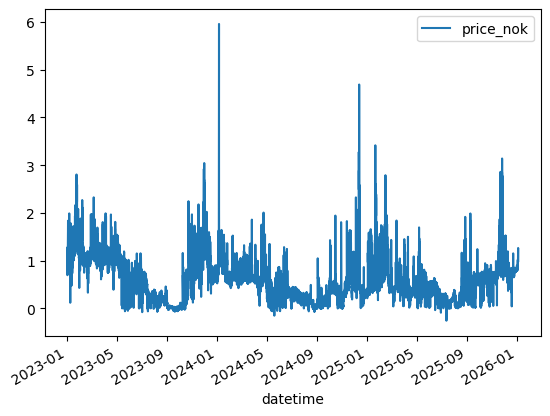

In [585]:
df.plot()

<Axes: xlabel='datetime'>

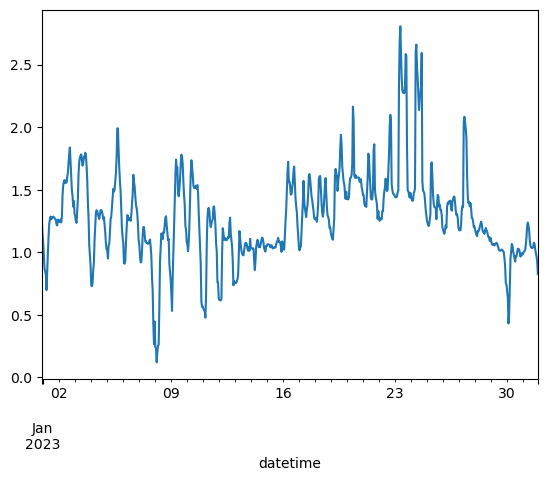

In [586]:
df["price_nok"].iloc[:744].plot()

### I started by exploring the structure of the price series itself. Electricity prices are not a generic time series; they exhibit strong hourly patterns, weekday effects, and longer seasonal movements.

### Before jumping into modeling, I wanted to understand how much of the variation could be explained by regular temporal structure alone. I therefore performed basic exploratory analysis and time series decomposition to separate trend, seasonality, and residual components.

### This step was not meant to produce a final model, but to build intuition about what kind of signals are present and which modeling directions might be reasonable.

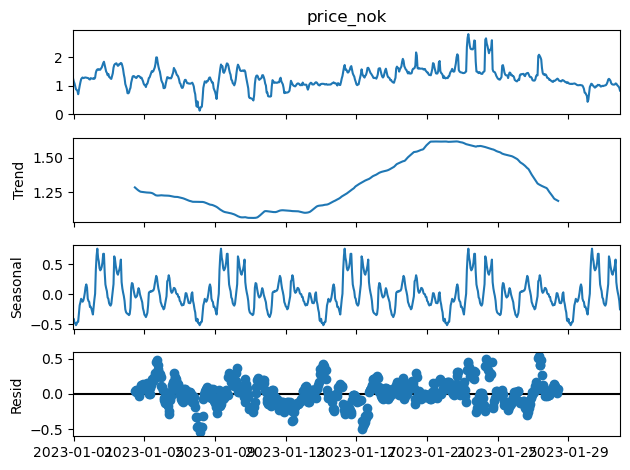

In [587]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df["price_nok"].iloc[:744], period=(24 * 7))

results.plot();

In [588]:
# #this is too messy use the above
# from statsmodels.tsa.seasonal import seasonal_decompose

# results = seasonal_decompose(df["price_nok"], period=(24 * 7))

# results.plot();

## Linear Regression

In [589]:
df.head()

,price_nok,zone
datetime,,
2022-12-31 23:00:00,1.25451,NO5
2023-01-01 00:00:00,1.14422,NO5
2023-01-01 01:00:00,1.07651,NO5
2023-01-01 02:00:00,0.97105,NO5
2023-01-01 03:00:00,0.86907,NO5


In [590]:
type(df)

pandas.core.frame.DataFrame

In [591]:
#df.index = pd.to_datetime(df.index)

In [592]:
#df.index = pd.DatetimeIndex(df.index).tz_localize(None)

In [593]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26376 entries, 2022-12-31 23:00:00 to 2026-01-03 22:00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price_nok  26376 non-null  float64
 1   zone       26376 non-null  object 
dtypes: float64(1), object(1)
memory usage: 618.2+ KB


In [594]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [595]:
df.index

DatetimeIndex(['2022-12-31 23:00:00', '2023-01-01 00:00:00',
               '2023-01-01 01:00:00', '2023-01-01 02:00:00',
               '2023-01-01 03:00:00', '2023-01-01 04:00:00',
               '2023-01-01 05:00:00', '2023-01-01 06:00:00',
               '2023-01-01 07:00:00', '2023-01-01 08:00:00',
               ...
               '2026-01-03 13:00:00', '2026-01-03 14:00:00',
               '2026-01-03 15:00:00', '2026-01-03 16:00:00',
               '2026-01-03 17:00:00', '2026-01-03 18:00:00',
               '2026-01-03 19:00:00', '2026-01-03 20:00:00',
               '2026-01-03 21:00:00', '2026-01-03 22:00:00'],
              dtype='datetime64[ns]', name='datetime', length=26376, freq=None)

In [596]:
# 1. Fix the index type
#df.index = pd.DatetimeIndex(df.index)


In [597]:
#df.index = pd.to_datetime(df.index, utc=True).tz_convert(None)


In [598]:
df.head()

,price_nok,zone
datetime,,
2022-12-31 23:00:00,1.25451,NO5
2023-01-01 00:00:00,1.14422,NO5
2023-01-01 01:00:00,1.07651,NO5
2023-01-01 02:00:00,0.97105,NO5
2023-01-01 03:00:00,0.86907,NO5


In [599]:
# lm_df = df.assign(
#     trend = range(len(df)).index,
#     hour = df.index.hour.astype("string"),
# #     day_of_week = electricity_df["Datetime"].dt.dayofweek.astype("string"),
# ).set_index("datetime")

# lm_df = pd.get_dummies(lm_df, drop_first=True)



In [600]:
#lm_df.info()

In [601]:
lm_df = df["price_nok"].reset_index()
lm_df.head()

,datetime,price_nok
0,2022-12-31 23:00:00,1.25451
1,2023-01-01 00:00:00,1.14422
2,2023-01-01 01:00:00,1.07651
3,2023-01-01 02:00:00,0.97105
4,2023-01-01 03:00:00,0.86907


In [602]:

# Feature engineering
lm_df = lm_df.assign(
    trend = lm_df.index,
   hour = lm_df["datetime"].dt.hour.astype("string"),
    day_of_week = lm_df["datetime"].dt.dayofweek.astype("string"),
   # month = lm_df["datetime"].dt.month.astype("string"),
    #taking month dummies is a very bad idea because electricity prices are not driven by what happened last month
    #but there is seasonal production best stuff at play that i will need to reconsider
).set_index("datetime")

lm_df.head()

,price_nok,trend,hour,day_of_week
datetime,,,,
2022-12-31 23:00:00,1.25451,0,23,5
2023-01-01 00:00:00,1.14422,1,0,6
2023-01-01 01:00:00,1.07651,2,1,6
2023-01-01 02:00:00,0.97105,3,2,6
2023-01-01 03:00:00,0.86907,4,3,6


In [603]:
# One-hot encode
lm_df = pd.get_dummies(lm_df, drop_first=True,dtype=int)

lm_df.head()

,price_nok,trend,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,hour_6,hour_7,hour_8,hour_9,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-31 23:00:00,1.25451,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-01-01 00:00:00,1.14422,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2023-01-01 01:00:00,1.07651,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2023-01-01 02:00:00,0.97105,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2023-01-01 03:00:00,0.86907,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### My initial modeling approach was deliberately simple. I started with linear regression models using only calendar-based features such as hour of day and day of week. The intention was to establish a transparent baseline that captures recurring patterns before introducing more complex dependencies.

### At this stage, I treated the models as diagnostic tools rather than final solutions. If a simple specification already performs poorly, it is usually a sign that more complexity is needed. If it performs reasonably well, it provides a strong reference point for judging whether additional features are actually adding value.

In [604]:
import statsmodels.api as sm

# lm_df_train = lm_df.loc[:"2025-11-30"]
# lm_df_test = lm_df.loc["2025-12-01": "2025-12-31"]

lm_df_train = lm_df.loc[:"2024-12-31"]
lm_df_test  = lm_df.loc["2025-01-01":"2025-01-31"]

# lm_df_train = lm_df.loc[:"2025-07-31"]
# lm_df_test = lm_df.loc["2025-08-01": "2025-08-31"]

# lm_df_train = lm_df.loc[:"2023-11-30"]
# lm_df_test = lm_df.loc["2023-12-01": "2023-12-31"]

X_train = sm.add_constant(lm_df_train.drop("price_nok", axis=1))
y_train = lm_df_train["price_nok"]

X_test = sm.add_constant(lm_df_test.drop("price_nok", axis=1))
y_test = lm_df_test["price_nok"]

In [605]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_nok   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     212.7
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        03:29:55   Log-Likelihood:                -7653.0
No. Observations:               17545   AIC:                         1.537e+04
Df Residuals:                   17514   BIC:                         1.561e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9345      0.016     57.559      0.000       0.903       0.966
trend          -4.14e-05   5.58e-07    -74.137      0.000   -4.25e-05   -4.03e-05
hour_1           -0.0105      0.020     -0.535      0.592      -0.049       0.028
hour_10           0.0654      0.020      3.335      0.001       0.027       0.104
hour_11           0.0380      0.020      1.941      0.052      -0.000       0.076
hour_12           0.0258      0.020      1.314      0.189      -0.013       0.064
hour_13           0.0412      0.020      2.101      0.036       0.003       0.080
hour_14           0.0773      0.020      3.947      0.000       0.039       0.116
hour_15           0.1255      0.020      6.405      0.000       0.087       0.164
hour_16           0.1709      0.020      8.721      0.000       0.132       0.209
hour_17           0.1739      0.020      8.876      0.000       0.136       0.212
hour_18           0.1442      0.020      7.360      0.000       0.106       0.183
hour_19           0.1119      0.020      5.713      0.000       0.074       0.150
hour_2           -0.0163      0.020     -0.834      0.404      -0.055       0.022
hour_20           0.0858      0.020      4.379      0.000       0.047       0.124
hour_21           0.0603      0.020      3.077      0.002       0.022       0.099
hour_22           0.0328      0.020      1.673      0.094      -0.006       0.071
hour_23           0.0175      0.020      0.894      0.371      -0.021       0.056
hour_3           -0.0081      0.020     -0.412      0.680      -0.046       0.030
hour_4            0.0289      0.020      1.475      0.140      -0.010       0.067
hour_5            0.0900      0.020      4.595      0.000       0.052       0.128
hour_6            0.1564      0.020      7.983      0.000       0.118       0.195
hour_7            0.1716      0.020      8.755      0.000       0.133       0.210
hour_8            0.1330      0.020      6.786      0.000       0.095       0.171
hour_9            0.0960      0.020      4.901      0.000       0.058       0.134
day_of_week_1     0.0269      0.011      2.545      0.011       0.006       0.048
day_of_week_2     0.0150      0.011      1.415      0.157      -0.006       0.036
day_of_week_3     0.0095      0.011      0.899      0.369      -0.011       0.030
day_of_week_4    -0.0176      0.011     -1.663      0.096      -0.038       0.003
day_of_week_5    -0.1069      0.011    -10.109      0.000      -0.128      -0.086
day_of_week_6    -0.1300      0.011    -12.315      0.000      -0.151      -0.109
==============================================================================
Omnibus:                     4169.703   Durbin-Watson:                   0.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45172.938
Skew:                           0.832   Prob(JB):         

In [606]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

#X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"MAE: {mae(y_test, model.predict(X_test))}")
print(f"MAPE: {mape(y_test, model.predict(X_test))}")

MAE: 0.3847825296366256
MAPE: 0.5242107467206498


<Axes: xlabel='datetime'>

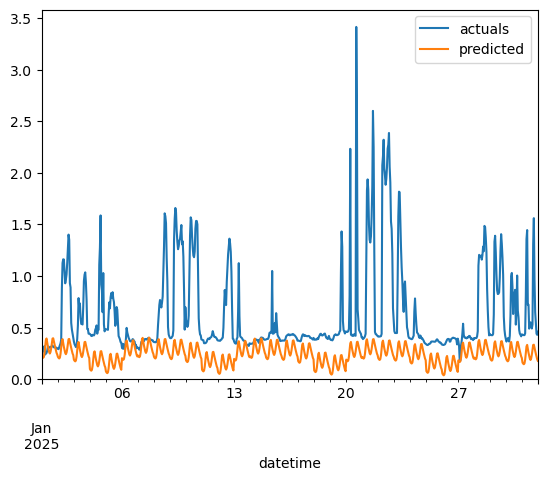

In [607]:
test_preds = pd.DataFrame({
    "actuals": y_test.values, 
    "predicted": model.predict(X_test)
})

test_preds.plot(ylim=0)

### **Because your model has no idea what happened one hour ago, and that’s everything in electricity prices. A linear model using only hourly seasonality fails to capture price dynamics, producing smooth average-based predictions that do not track level changes. This confirms strong temporal dependence in electricity prices and motivates the inclusion of lagged price features.**

In [608]:
# YES BUT still i refuse to agree. it shouldnt be this much off. lets try to bring our train and test dates closer 
# because inflation and shit

In [609]:

df.query('price_nok < 0')

,price_nok,zone
datetime,,
2023-05-20 10:00:00,-0.00174,NO5
2023-05-20 11:00:00,-0.00639,NO5
2023-05-20 12:00:00,-0.00105,NO5
2023-05-21 09:00:00,-0.00562,NO5
2023-05-21 10:00:00,-0.04505,NO5
...,...,...
2025-07-14 02:00:00,-0.03786,NO5
2025-07-14 03:00:00,-0.00639,NO5
2025-07-14 04:00:00,-0.00071,NO5


There is actually no reason to worry aobut this since norwegian electricity prices can ACTUALLY HAVE negative prices.

Check out this https://montel.energy/resources/blog/why-do-negative-prices-occur-in-nordic-energy-hours
or this https://www.reddit.com/r/Norway/comments/1f1ycjq/what_does_it_mean_the_electricity_price_is/

In [610]:
lm_df.head()

,price_nok,trend,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,hour_6,hour_7,hour_8,hour_9,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-31 23:00:00,1.25451,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2023-01-01 00:00:00,1.14422,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2023-01-01 01:00:00,1.07651,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2023-01-01 02:00:00,0.97105,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2023-01-01 03:00:00,0.86907,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [611]:
lm_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26376 entries, 2022-12-31 23:00:00 to 2026-01-03 22:00:00
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price_nok      26376 non-null  float64
 1   trend          26376 non-null  int64  
 2   hour_1         26376 non-null  int32  
 3   hour_10        26376 non-null  int32  
 4   hour_11        26376 non-null  int32  
 5   hour_12        26376 non-null  int32  
 6   hour_13        26376 non-null  int32  
 7   hour_14        26376 non-null  int32  
 8   hour_15        26376 non-null  int32  
 9   hour_16        26376 non-null  int32  
 10  hour_17        26376 non-null  int32  
 11  hour_18        26376 non-null  int32  
 12  hour_19        26376 non-null  int32  
 13  hour_2         26376 non-null  int32  
 14  hour_20        26376 non-null  int32  
 15  hour_21        26376 non-null  int32  
 16  hour_22        26376 non-null  int32  
 17  hour_23        



### After testing purely calendar-based models, it became clear that past prices contain substantial information about future prices. This aligns with findings in the electricity price forecasting literature, where autoregressive effects are consistently reported as strong predictors.

### I therefore experimented with lagged price features, focusing primarily on a 24-hour lag. The choice of t-24 is practical: it reflects daily repetition in consumption and production patterns while remaining compatible with a day-ahead forecasting setup.

### Shorter lags such as t-1 can improve accuracy, but they also blur the line between forecasting and "nowcasting". Since the aim here is a realistic day-ahead forecast, I avoided relying on information that would not be robustly available at prediction time.

In [612]:
lm_lag = lm_df.assign(
   # price_lag_1 = lm_df["price_nok"].shift(1),
    price_lag_24 = lm_df["price_nok"].shift(24),
)

In [613]:
lm_lag.head()

,price_nok,trend,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,hour_7,hour_8,hour_9,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,price_lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2022-12-31 23:00:00,1.25451,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,NaN
2023-01-01 00:00:00,1.14422,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,NaN
2023-01-01 01:00:00,1.07651,2,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,NaN
2023-01-01 02:00:00,0.97105,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,NaN
2023-01-01 03:00:00,0.86907,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,NaN


In [614]:
lm_lag = lm_lag.dropna()

In [615]:
lm_lag.head()

,price_nok,trend,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,hour_7,hour_8,hour_9,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,price_lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-01 23:00:00,1.26124,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.25451
2023-01-02 00:00:00,1.25314,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.14422
2023-01-02 01:00:00,1.24252,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.07651
2023-01-02 02:00:00,1.24178,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.97105
2023-01-02 03:00:00,1.26155,28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.86907


In [616]:
# lm_lag_train = lm_lag.loc[:"2025-11-30"]
# lm_lag_test = lm_lag.loc["2025-12-01": "2025-12-31"]

#lm_lag_train = lm_lag.loc[:"2024-12-31"]   #main set
#lm_lag_test  = lm_lag.loc["2025-01-01":"2025-01-31"]

lm_lag_train = lm_lag.loc[:"2025-11-30"]
lm_lag_test  = lm_lag.loc["2025-12-01":"2026-01-3"]


X_train = sm.add_constant(lm_lag_train.drop("price_nok", axis=1))
y_train = lm_lag_train["price_nok"]

X_test = sm.add_constant(lm_lag_test.drop("price_nok", axis=1))
y_test = lm_lag_test["price_nok"]





In [617]:
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_nok   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     2199.
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        03:29:55   Log-Likelihood:                 3107.3
No. Observations:               25537   AIC:                            -6151.
Df Residuals:                   25505   BIC:                            -5890.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2272      0.008     28.290      0.000       0.211       0.243
trend         -2.923e-06   1.93e-07    -15.163      0.000    -3.3e-06   -2.55e-06
hour_1           -0.0017      0.009     -0.179      0.858      -0.020       0.017
hour_10           0.0112      0.009      1.209      0.227      -0.007       0.029
hour_11           0.0065      0.009      0.698      0.485      -0.012       0.025
hour_12           0.0049      0.009      0.524      0.600      -0.013       0.023
hour_13           0.0082      0.009      0.881      0.379      -0.010       0.026
hour_14           0.0148      0.009      1.595      0.111      -0.003       0.033
hour_15           0.0241      0.009      2.587      0.010       0.006       0.042
hour_16           0.0322      0.009      3.458      0.001       0.014       0.050
hour_17           0.0321      0.009      3.446      0.001       0.014       0.050
hour_18           0.0272      0.009      2.916      0.004       0.009       0.045
hour_19           0.0209      0.009      2.245      0.025       0.003       0.039
hour_2           -0.0025      0.009     -0.273      0.785      -0.021       0.016
hour_20           0.0158      0.009      1.697      0.090      -0.002       0.034
hour_21           0.0106      0.009      1.137      0.256      -0.008       0.029
hour_22           0.0058      0.009      0.620      0.535      -0.012       0.024
hour_23           0.0031      0.009      0.331      0.741      -0.015       0.021
hour_3           -0.0009      0.009     -0.094      0.926      -0.019       0.017
hour_4            0.0054      0.009      0.577      0.564      -0.013       0.024
hour_5            0.0169      0.009      1.821      0.069      -0.001       0.035
hour_6            0.0288      0.009      3.097      0.002       0.011       0.047
hour_7            0.0307      0.009      3.293      0.001       0.012       0.049
hour_8            0.0241      0.009      2.585      0.010       0.006       0.042
hour_9            0.0173      0.009      1.864      0.062      -0.001       0.036
day_of_week_1    -0.0649      0.005    -12.885      0.000      -0.075      -0.055
day_of_week_2    -0.0946      0.005    -18.734      0.000      -0.104      -0.085
day_of_week_3    -0.1014      0.005    -20.097      0.000      -0.111      -0.092
day_of_week_4    -0.1198      0.005    -23.742      0.000      -0.130      -0.110
day_of_week_5    -0.1944      0.005    -38.600      0.000      -0.204      -0.185
day_of_week_6    -0.1331      0.005    -26.522      0.000      -0.143      -0.123
price_lag_24      0.8255      0.004    233.276      0.000       0.819       0.832
==============================================================================
Omnibus:                    11246.193   Durbin-Watson:                   0.275
Prob(Omnibus):                  0.000   Jarque-Bera (JB

In [618]:
print(f"MAE: {mae(y_test, model.predict(X_test))}")
print(f"MAPE: {mape(y_test, model.predict(X_test))}")

MAE: 0.11859351123576663
MAPE: 0.18379731354508402


<Axes: xlabel='datetime'>

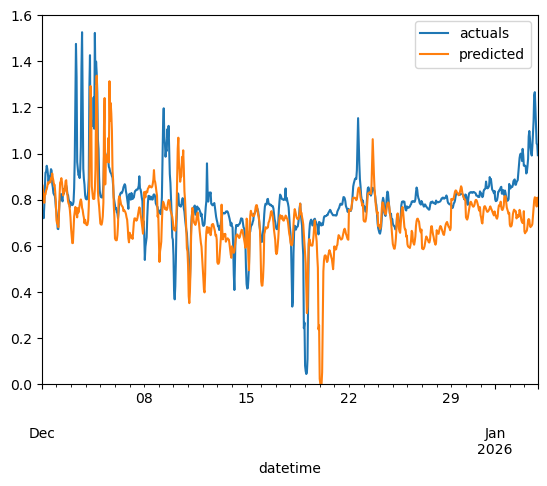

In [619]:
test_preds = pd.DataFrame({
    "actuals": y_test.values, 
    "predicted": model.predict(X_test)
})

test_preds.plot(ylim=0)

### Now lets try XG-boost because,
### Although linear regression performs surprisingly well, electricity prices are shaped by nonlinear interactions, threshold effects, and regime changes that a linear model cannot fully capture.

### To explore whether such nonlinearities could be learned from the data, I tested XGBoost as an alternative modeling approach. XGBoost is well suited for structured tabular data and is widely used in short-term electricity price forecasting.

### The goal was not to replace linear regression by default, but to evaluate whether a more flexible model could improve predictive accuracy without sacrificing stability or interpretability.

In [620]:
#validation Split
val_cutoff = "2025-09-30"

X_tr = X_train.loc[:val_cutoff]
y_tr = y_train.loc[:val_cutoff]

X_val = X_train.loc[val_cutoff:]
y_val = y_train.loc[val_cutoff:]

In [621]:
#Train a conservative XGBoost model

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [622]:
# #Fit with early stopping
# xgb_model.fit(
#     X_tr, y_tr,
#     eval_set=[(X_val, y_val)],
#     eval_metric="mae",
#     early_stopping_rounds=30,
#     verbose=True
# )


from xgboost import XGBRegressor
import xgboost as xgb

# xgb_model = XGBRegressor(
#     objective="reg:squarederror",
#     eval_metric="mae",          # ← MOVE IT HERE
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=4,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42,
#     n_jobs=-1
# )


# xgb_model.fit(
#     X_tr, y_tr,
#     eval_set=[(X_val, y_val)],
#     callbacks=[xgb.callback.EarlyStopping(rounds=30)],
#     verbose=True
# )

In [623]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)


params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}


xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dval, "validation")],
    early_stopping_rounds=30,
    verbose_eval=True
)

[0]	validation-mae:0.22324
[1]	validation-mae:0.21605
[2]	validation-mae:0.21020
[3]	validation-mae:0.21432
[4]	validation-mae:0.20911
[5]	validation-mae:0.20407
[6]	validation-mae:0.20785
[7]	validation-mae:0.20356
[8]	validation-mae:0.19915
[9]	validation-mae:0.19571
[10]	validation-mae:0.19248
[11]	validation-mae:0.19673
[12]	validation-mae:0.19360
[13]	validation-mae:0.19072
[14]	validation-mae:0.18840
[15]	validation-mae:0.19074
[16]	validation-mae:0.19302
[17]	validation-mae:0.19137
[18]	validation-mae:0.18902
[19]	validation-mae:0.18693
[20]	validation-mae:0.18484
[21]	validation-mae:0.18308
[22]	validation-mae:0.18163
[23]	validation-mae:0.18004
[24]	validation-mae:0.17865
[25]	validation-mae:0.17731
[26]	validation-mae:0.17704
[27]	validation-mae:0.17639
[28]	validation-mae:0.17756
[29]	validation-mae:0.17691
[30]	validation-mae:0.17595
[31]	validation-mae:0.17490
[32]	validation-mae:0.17402
[33]	validation-mae:0.17310
[34]	validation-mae:0.17210
[35]	validation-mae:0.17145
[3

In [624]:

#Evaluate on the test set
from sklearn.metrics import mean_absolute_error

xgb_preds = xgb_model.predict(dtest)


from sklearn.metrics import mean_absolute_error

print("XGBoost MAE:", mean_absolute_error(y_test, xgb_preds))

XGBoost MAE: 0.11249688980613898


<Axes: xlabel='datetime'>

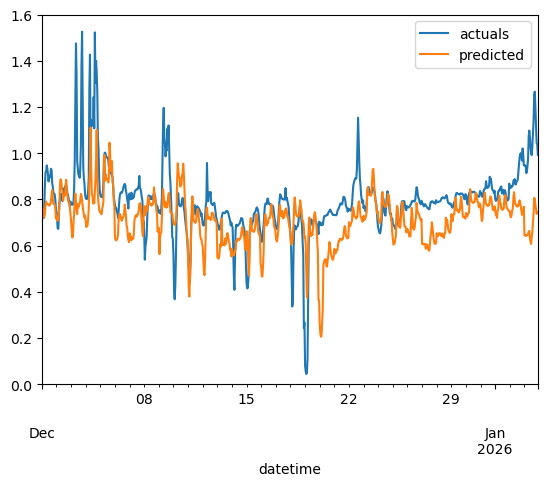

In [625]:
#Plot predicted vs actual
test_preds_xgb = pd.DataFrame(
    {
        "actuals": y_test.values,
        "predicted": xgb_preds
    },
    index=y_test.index
)

test_preds_xgb.plot(ylim=0)

In [626]:
#Feature importance
# import pandas as pd

# importance = pd.Series(
#     xgb_model.feature_importances_,
#     index=X_train.columns
# ).sort_values(ascending=False)

# importance.head(10)

In [627]:
lm_lag.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26352 entries, 2023-01-01 23:00:00 to 2026-01-03 22:00:00
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price_nok      26352 non-null  float64
 1   trend          26352 non-null  int64  
 2   hour_1         26352 non-null  int32  
 3   hour_10        26352 non-null  int32  
 4   hour_11        26352 non-null  int32  
 5   hour_12        26352 non-null  int32  
 6   hour_13        26352 non-null  int32  
 7   hour_14        26352 non-null  int32  
 8   hour_15        26352 non-null  int32  
 9   hour_16        26352 non-null  int32  
 10  hour_17        26352 non-null  int32  
 11  hour_18        26352 non-null  int32  
 12  hour_19        26352 non-null  int32  
 13  hour_2         26352 non-null  int32  
 14  hour_20        26352 non-null  int32  
 15  hour_21        26352 non-null  int32  
 16  hour_22        26352 non-null  int32  
 17  hour_23        

### Weather conditions influence electricity prices through both demand and supply channels. Temperature affects heating demand, while also interacting with hydropower availability and broader system conditions.

### I chose to start with air temperature as a first weather variable because it is widely available, easy to interpret, and commonly used in prior studies. The intention here is not to claim that temperature alone explains price movements, but to test whether it adds incremental explanatory power on top of temporal structure and lagged prices.

### Given Bergen’s volatile and rapidly changing weather, I focused on contemporaneous temperature rather than temperature forecasts far into the future.

In [628]:
weather = pd.read_csv("weather_data.csv", sep=";")

weather = weather[[
    "Time(norwegian mean time)",
    "Air temperature"
]]

weather.head()

,Time(norwegian mean time),Air temperature
0,01.01.2023 01:00,-0.8
1,01.01.2023 02:00,0.5
2,01.01.2023 03:00,-0.9
3,01.01.2023 04:00,-1.8
4,01.01.2023 05:00,-1.9


In [629]:
weather["datetime"] = pd.to_datetime(
    weather["Time(norwegian mean time)"],
    format="%d.%m.%Y %H:%M"
)
weather = weather.drop(columns="Time(norwegian mean time)")
weather.head()

,Air temperature,datetime
0,-0.8,2023-01-01 01:00:00
1,0.5,2023-01-01 02:00:00
2,-0.9,2023-01-01 03:00:00
3,-1.8,2023-01-01 04:00:00
4,-1.9,2023-01-01 05:00:00


In [630]:
weather = weather.set_index("datetime")
weather.head()

,Air temperature
datetime,
2023-01-01 01:00:00,-0.8
2023-01-01 02:00:00,0.5
2023-01-01 03:00:00,-0.9
2023-01-01 04:00:00,-1.8
2023-01-01 05:00:00,-1.9


In [631]:
weather = weather.rename(columns={
    "Air temperature": "temperature"
})

weather["temperature"] = pd.to_numeric(weather["temperature"], errors="coerce")

weather.head()

,temperature
datetime,
2023-01-01 01:00:00,-0.8
2023-01-01 02:00:00,0.5
2023-01-01 03:00:00,-0.9
2023-01-01 04:00:00,-1.8
2023-01-01 05:00:00,-1.9


In [632]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26377 entries, 2023-01-01 01:00:00 to NaT
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  26315 non-null  float64
dtypes: float64(1)
memory usage: 412.1 KB


In [633]:
# THE JOINING
lm_lag_weather = lm_lag.join(weather, how="left")

In [634]:
lm_lag_weather.head()

,price_nok,trend,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,hour_8,hour_9,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,price_lag_24,temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-01 23:00:00,1.26124,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.25451,-2.2
2023-01-02 00:00:00,1.25314,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.14422,-2.1
2023-01-02 01:00:00,1.24252,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.07651,-2.1
2023-01-02 02:00:00,1.24178,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.97105,-3.0
2023-01-02 03:00:00,1.26155,28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.86907,-3.0


In [635]:
lm_lag_weather["temperature"].isna().sum()

61

In [636]:
lm_lag_weather = lm_lag_weather.dropna(subset=["temperature"])


In [637]:
#train / test split

# lm_lag_weather_train = lm_lag_weather.loc[:"2025-11-30"]
# lm_lag_weather_test  = lm_lag_weather.loc["2025-12-01":"2026-01-03"]

lm_lag_weather_train = lm_lag_weather.loc[:"2025-12-31"]
lm_lag_weather_test  = lm_lag_weather.loc["2026-01-01":"2026-01-03"]

X_train = sm.add_constant(lm_lag_weather_train.drop("price_nok", axis=1))
y_train = lm_lag_weather_train["price_nok"]

X_test = sm.add_constant(lm_lag_weather_test.drop("price_nok", axis=1))
y_test = lm_lag_weather_test["price_nok"]

In [638]:
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_nok   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     2419.
Date:                Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                        03:29:56   Log-Likelihood:                 4389.1
No. Observations:               26220   AIC:                            -8712.
Df Residuals:                   26187   BIC:                            -8442.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3516      0.008     43.483      0.000       0.336       0.367
trend         -2.695e-06   1.74e-07    -15.467      0.000   -3.04e-06   -2.35e-06
hour_1           -0.0045      0.009     -0.518      0.605      -0.022       0.013
hour_10           0.0402      0.009      4.572      0.000       0.023       0.057
hour_11           0.0404      0.009      4.588      0.000       0.023       0.058
hour_12           0.0434      0.009      4.931      0.000       0.026       0.061
hour_13           0.0512      0.009      5.808      0.000       0.034       0.068
hour_14           0.0621      0.009      7.031      0.000       0.045       0.079
hour_15           0.0760      0.009      8.577      0.000       0.059       0.093
hour_16           0.0857      0.009      9.655      0.000       0.068       0.103
hour_17           0.0809      0.009      9.133      0.000       0.064       0.098
hour_18           0.0685      0.009      7.746      0.000       0.051       0.086
hour_19           0.0524      0.009      5.944      0.000       0.035       0.070
hour_2           -0.0075      0.009     -0.856      0.392      -0.025       0.010
hour_20           0.0395      0.009      4.492      0.000       0.022       0.057
hour_21           0.0269      0.009      3.060      0.002       0.010       0.044
hour_22           0.0151      0.009      1.721      0.085      -0.002       0.032
hour_23           0.0073      0.009      0.828      0.408      -0.010       0.024
hour_3           -0.0061      0.009     -0.695      0.487      -0.023       0.011
hour_4            0.0027      0.009      0.309      0.757      -0.014       0.020
hour_5            0.0202      0.009      2.307      0.021       0.003       0.037
hour_6            0.0402      0.009      4.579      0.000       0.023       0.057
hour_7            0.0479      0.009      5.445      0.000       0.031       0.065
hour_8            0.0443      0.009      5.036      0.000       0.027       0.061
hour_9            0.0418      0.009      4.751      0.000       0.025       0.059
day_of_week_1    -0.0517      0.005    -10.898      0.000      -0.061      -0.042
day_of_week_2    -0.0760      0.005    -15.964      0.000      -0.085      -0.067
day_of_week_3    -0.0848      0.005    -17.811      0.000      -0.094      -0.076
day_of_week_4    -0.1040      0.005    -21.820      0.000      -0.113      -0.095
day_of_week_5    -0.1763      0.005    -37.071      0.000      -0.186      -0.167
day_of_week_6    -0.1247      0.005    -26.356      0.000      -0.134      -0.115
price_lag_24      0.7291      0.004    184.037      0.000       0.721       0.737
temperature      -0.0114      0.000    -46.216      0.000      -0.012      -0.011
==============================================================================
Omnibus:                    11798.136   Durbin-Watso

In [639]:
print(f"MAE: {mae(y_test, model.predict(X_test))}")
print(f"MAPE: {mape(y_test, model.predict(X_test))}")

MAE: 0.0959641269557041
MAPE: 0.09725112718397827


<Axes: xlabel='datetime'>

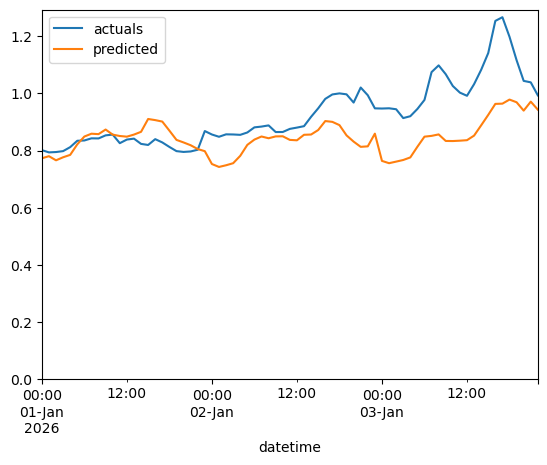

In [640]:
test_preds = pd.DataFrame({
    "actuals": y_test.values, 
    "predicted": model.predict(X_test)
})

test_preds.plot(ylim=0)

## Lets try XG boost on this. 

In [641]:
lm_lag_weather.head()

,price_nok,trend,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,hour_8,hour_9,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,price_lag_24,temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2023-01-01 23:00:00,1.26124,24,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1.25451,-2.2
2023-01-02 00:00:00,1.25314,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.14422,-2.1
2023-01-02 01:00:00,1.24252,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1.07651,-2.1
2023-01-02 02:00:00,1.24178,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.97105,-3.0
2023-01-02 03:00:00,1.26155,28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.86907,-3.0


In [642]:
#validation Split
val_cutoff = "2025-09-30"

X_tr = X_train.loc[:val_cutoff]
y_tr = y_train.loc[:val_cutoff]

X_val = X_train.loc[val_cutoff:]
y_val = y_train.loc[val_cutoff:]

In [643]:
#Train a conservative XGBoost model

from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

In [644]:
from xgboost import XGBRegressor
import xgboost as xgb

In [645]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval   = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test, label=y_test)


params = {
    "objective": "reg:squarederror",
    "eval_metric": "mae",
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}


xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dval, "validation")],
    early_stopping_rounds=30,
    verbose_eval=True
)

[0]	validation-mae:0.21812
[1]	validation-mae:0.21138
[2]	validation-mae:0.20546
[3]	validation-mae:0.19960
[4]	validation-mae:0.19419
[5]	validation-mae:0.18853
[6]	validation-mae:0.18366
[7]	validation-mae:0.17857
[8]	validation-mae:0.17441
[9]	validation-mae:0.17196
[10]	validation-mae:0.16779
[11]	validation-mae:0.16471
[12]	validation-mae:0.16220
[13]	validation-mae:0.15943
[14]	validation-mae:0.16011
[15]	validation-mae:0.15695
[16]	validation-mae:0.15747
[17]	validation-mae:0.15454
[18]	validation-mae:0.15191
[19]	validation-mae:0.14969
[20]	validation-mae:0.14794
[21]	validation-mae:0.14593
[22]	validation-mae:0.14402
[23]	validation-mae:0.14261
[24]	validation-mae:0.14092
[25]	validation-mae:0.13983
[26]	validation-mae:0.13838
[27]	validation-mae:0.13896
[28]	validation-mae:0.13750
[29]	validation-mae:0.13800
[30]	validation-mae:0.13651
[31]	validation-mae:0.13644
[32]	validation-mae:0.13532
[33]	validation-mae:0.13450
[34]	validation-mae:0.13350
[35]	validation-mae:0.13266
[3

In [646]:
#Evaluate on the test set
from sklearn.metrics import mean_absolute_error

xgb_preds = xgb_model.predict(dtest)


from sklearn.metrics import mean_absolute_error

print("XGBoost MAE:", mean_absolute_error(y_test, xgb_preds))

XGBoost MAE: 0.11054727262228306


<Axes: xlabel='datetime'>

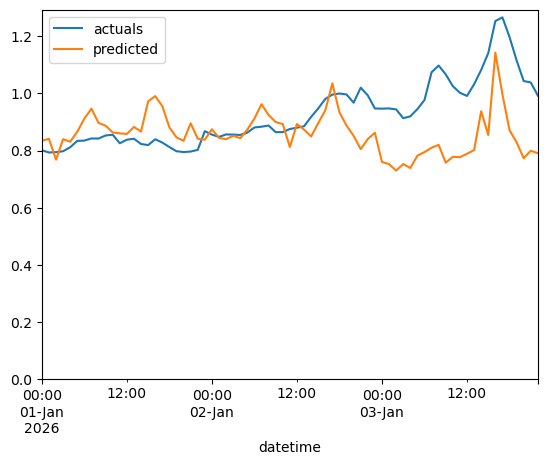

In [647]:
#Plot predicted vs actual
test_preds_xgb = pd.DataFrame(
    {
        "actuals": y_test.values,
        "predicted": xgb_preds
    },
    index=y_test.index
)

test_preds_xgb.plot(ylim=0)

### After comparing multiple specifications, including linear models with different lag structures and XGBoost-based approaches, I decided to proceed with the OLS model that includes hour indicators, weekday indicators, a 24-hour price lag, and temperature.

### While XGBoost can capture nonlinear effects, the gains in accuracy were limited relative to the added complexity and tuning effort. In contrast, the OLS model offers strong performance, stability across time, and clear interpretability of coefficients.

### Given the goal of deploying this model in a live dashboard and explaining its behavior to non-technical users, the simpler model provides a better trade-off between accuracy and transparency.

In [648]:
import pandas as pd
import statsmodels.api as sm




### The final step is to simulate a realistic day-ahead forecasting scenario. The model is trained on historical data and used to predict the next 24 hours of prices. These forecasts are then compared against actual realized prices once they become available.

### This setup allows continuous evaluation of model performance over time. Rather than reporting a single accuracy number, the model’s strengths and weaknesses remain visible, especially during price spikes or unusual market conditions.

In [659]:
test_preds = pd.DataFrame(
    {
        "actual": y_test,
        "predicted": model.predict(X_test)
    },
    index=lm_lag_weather_test.index
)


tomorrow_prices_plot = tomorrow_prices.rename(
    columns={"price_forecast": "predicted"}
)

combined = pd.concat(
    [test_preds[["actual", "predicted"]], tomorrow_prices_plot],
    axis=0
)

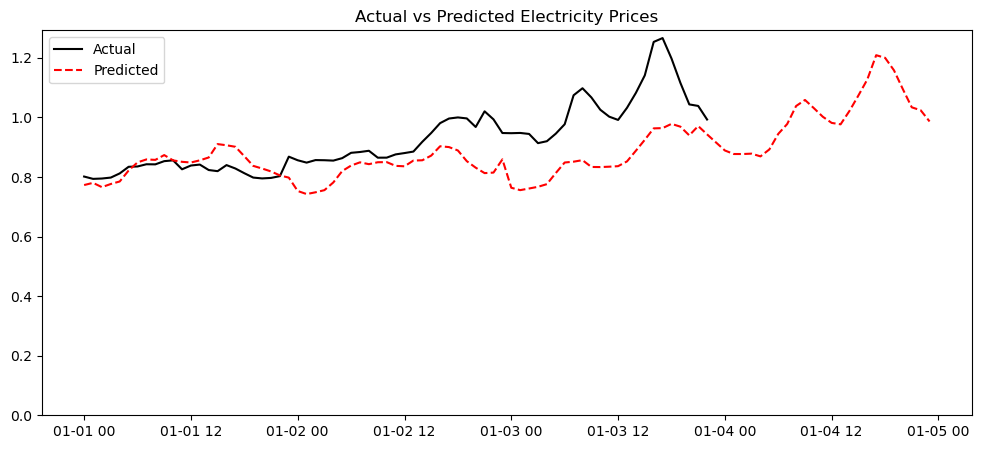

In [660]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.plot(
    combined.index,
    combined["actual"],
    label="Actual",
    color="black"
)

plt.plot(
    combined.index,
    combined["predicted"],
    label="Predicted",
    linestyle="--",
    color="red"
)

plt.legend()
plt.ylim(0)
plt.title("Actual vs Predicted Electricity Prices")
plt.show()


In [662]:
tomorrow_prices_plot

,predicted
2026-01-04 00:00:00,0.888824
2026-01-04 01:00:00,0.876996
2026-01-04 02:00:00,0.876920
2026-01-04 03:00:00,0.878195
2026-01-04 04:00:00,0.869031
2026-01-04 05:00:00,0.892446
2026-01-04 06:00:00,0.944635
2026-01-04 07:00:00,0.977618
2026-01-04 08:00:00,1.038024
2026-01-04 09:00:00,1.058415


In [663]:
import requests
import pandas as pd

year = 2026
month = "01"
day = "04"
zone = "NO5"

url = f"https://www.hvakosterstrommen.no/api/v1/prices/{year}/{month}-{day}_{zone}.json"

response = requests.get(url)
response.raise_for_status()

data = response.json()

df_no5_0401 = pd.DataFrame({
    "datetime": [entry["time_start"] for entry in data],
    "price_nok": [entry["NOK_per_kWh"] for entry in data]
})

df_no5_0401["datetime"] = pd.to_datetime(df_no5_0401["datetime"])
df_no5_0401 = df_no5_0401.set_index("datetime")

df_no5_0401


,price_nok
datetime,
2026-01-04 00:00:00+01:00,0.99096
2026-01-04 01:00:00+01:00,0.97526
2026-01-04 02:00:00+01:00,0.97184
2026-01-04 03:00:00+01:00,0.95733
2026-01-04 04:00:00+01:00,0.94530
2026-01-04 05:00:00+01:00,0.95391
2026-01-04 06:00:00+01:00,0.95804
2026-01-04 07:00:00+01:00,0.98978
2026-01-04 08:00:00+01:00,1.01007
